In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance as dist
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zipcodes = pd.read_csv('zipcode_data.csv')
storage_data = pd.read_csv('storage_data.csv')
generation_data = pd.read_csv('generation_data.csv')

### Functions for looking up stuff

In [3]:
def get_latlong_from_zip(zipcode):
    """
    Given a zipcode, return its latitude and longitude as a tuple.
    
    """
    
    if not np.issubdtype(type(zipcode), np.integer):
        raise TypeError("Enter a numeric zipcode.")
        
    row = zipcodes[zipcodes.zip == zipcode]
    if len(row) == 1:
        return (row.iloc[0,3], row.iloc[0,4])
    else:
        print("Not a valid zipcode.")
        return None

In [4]:
def get_distances(latlong, facility_data):
    """
    Given a latitude-longitude tuple and a dataframe containing .lat and .long columns,
    calculate the Euclidean distances between that location and all rows in the dataframe
    and append the distances as a column to the dataframe.
    
    """
    
    distances = []
    for index, row in facility_data.iterrows():
        facility_latlong = (row.lat, row.lon)
        distances.append(dist.euclidean(latlong, facility_latlong))
    facility_data['zip_dist'] = distances

In [8]:
def get_closest_facility(latlong, facility_data):
    """
    Given a latitude-longitude tuple and a dataframe of energy facilities with lat and lon columns,
    return information about the closest facility to that location.
    
    Calculates and stores distances to all facilities if they are not already in the dataframe.
    
    """
    
    # Check whether zip_dist has already been calculated for this zipcode
    row = facility_data.iloc[0]
    facility_latlong = (row.lat, row.lon)
    if 'zip_dist' not in facility_data.columns \
    or not np.isclose(dist.euclidean(latlong, facility_latlong), facility_data.zip_dist):
        get_distances(latlong, facility_data)
        
    closest = facility_data.zip_dist.idxmin()
    return facility_data.iloc[closest]

### Demonstration of lookup functions
These would be incorporated into the GUI along with our KNN predictions and state- and national-level data. Ultimately, the user should be able to enter a zipcode and get:
1. predicted generation and storage types
2. type, name, and location of nearest generation and storage facilities
3. breakdown of generation and storage types for their state
4. breakdown of generation and storage types for the entire US

In [6]:
get_latlong_from_zip(98105)

(47.66377, -122.30118)

In [9]:
get_closest_facility(get_latlong_from_zip(98105), generation_data)

state                                           WA
name          University of Washington Power Plant
lat                                        47.6539
lon                                       -122.304
type                                           GAS
capacity                                        15
production                                 12.3075
zip_dist                                 0.0101623
Name: 8179, dtype: object

In [10]:
get_closest_facility(get_latlong_from_zip(98105), storage_data)

name        Seattle City Light Microgrid
lat                              47.6062
lon                             -122.332
type2                   Electro-chemical
type                    Electro-chemical
power_kW                               0
duration                             n/a
status                         Announced
usecase       Electric Energy Time Shift
city                             Seattle
state                         Washington
zip_dist                       0.0653257
Name: 110, dtype: object

### Plotting facilities in a few different ways

I just wanted to check and see how these looked, even though we'll ultimately do this using gmaps or some other mapping package.

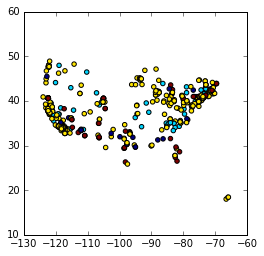

In [11]:
levels,labels = pd.factorize(storage_data.type)
plt.figure(figsize=(4,4))
plt.scatter(storage_data.lon, storage_data.lat, c=levels)
plt.ylim(10,60)
plt.xlim(-130,-60)
plt.show()

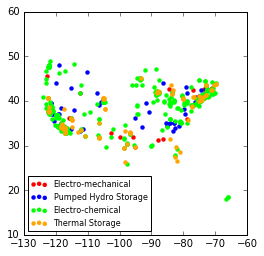

In [12]:
plt.figure(figsize=(4,4))
colors = ['red', 'blue', 'lime', 'orange']
for i in range(0,len(labels)):
    tp = labels[i]
    subset = storage_data[storage_data.type==tp]
    plt.scatter(subset.lon, subset.lat, label=tp, c=colors[i], lw=0)
plt.ylim(10,60)
plt.xlim(-130,-60)
plt.legend(fontsize=8, loc=3)
plt.show()

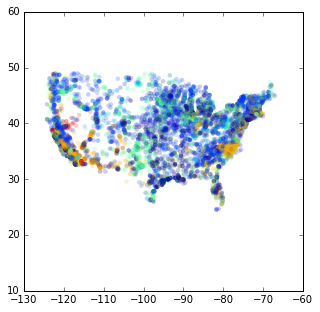

In [13]:
levels,labels = pd.factorize(generation_data.type)
plt.figure(figsize=(5,5))
plt.scatter(generation_data.lon, generation_data.lat, c=levels, lw=0, alpha=0.2)
plt.ylim(10,60)
plt.xlim(-130,-60)
plt.show()

### KNN
This is a rough first attempt at a KNN model based on an arbitrary K and no weighting by facility size or capacity.

Initialize and fit KNN models:

In [14]:
storage_clf = KNeighborsClassifier(n_neighbors=1, weights='uniform')
storage_clf.fit(storage_data[['lat','lon']],storage_data['type'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [15]:
generation_clf = KNeighborsClassifier(n_neighbors=1, weights='uniform')
generation_clf.fit(generation_data[['lat','lon']],generation_data['type'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Use KNNs to predict generation and storage types for a specific zipcode:

In [16]:
storage_clf.predict(np.array([get_latlong_from_zip(98105)]))[0]

'Electro-chemical'

In [17]:
generation_clf.predict(np.array([get_latlong_from_zip(98105)]))[0]

'GAS'

Use KNNs to predict generation and storage types for all zipcodes in the zipcode database, and save the results as a column of the zipcode database:

In [18]:
pred_storage = []
pred_generation = []
for zipcode in zipcodes.zip:
    pred_storage.append(storage_clf.predict(np.array([get_latlong_from_zip(zipcode)]))[0])
    pred_generation.append(generation_clf.predict(np.array([get_latlong_from_zip(zipcode)]))[0])

In [19]:
zipcodes['pred_storage'] = pred_storage
zipcodes['pred_generation'] = pred_generation

Make a really rough heatmap by making a scatter plot of the predicted storage types:

(-130, -60)

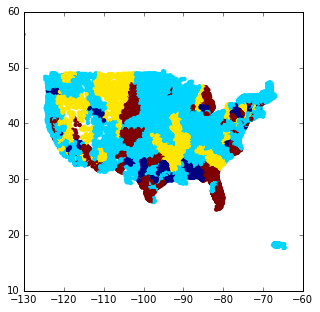

In [20]:
levels,labels = pd.factorize(zipcodes.pred_storage)
plt.figure(figsize=(5,5))
plt.scatter(zipcodes.longitude, zipcodes.latitude, marker='o', c=levels, lw=0)
plt.ylim(10,60)
plt.xlim(-130,-60)

(-130, -60)

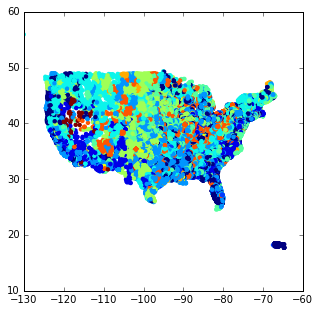

In [21]:
levels,labels = pd.factorize(zipcodes.pred_generation)
plt.figure(figsize=(5,5))
plt.scatter(zipcodes.longitude, zipcodes.latitude, marker='o', c=levels, lw=0)
plt.ylim(10,60)
plt.xlim(-130,-60)